In [1]:
!git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 4.58 KiB | 1.53 MiB/s, done.
From https://github.com/anshks/AudioSet-classification
   d67fefd..ce371d3  main       -> origin/main
Updating d67fefd..ce371d3
Fast-forward
 RnnCnn.ipynb | 555 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 555 insertions(+)
 create mode 100644 RnnCnn.ipynb

This repository is configured for Git LFS but 'git-lfs' was not found on your path. If you no longer wish to use Git LFS, remove this hook by deleting the 'post-merge' file in the hooks directory (set by 'core.hookspath'; usually '.git/hooks').



In [1]:
import os
import torchaudio
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import torch
import matplotlib.pyplot as plt

In [2]:
SAMPLE_RATE = 16000
N_MFCC = 13
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 128
DATA_PATH = '/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data'

In [3]:
def extract_mfcc_features(waveforms):
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        melkwargs={"n_fft": N_FFT, "hop_length": HOP_LENGTH, "n_mels": N_MELS}
    )
    return mfcc_transform(waveforms).numpy()

In [4]:
def extract_mel_spectrogram_features(waveforms):
    mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    return mel_spectrogram_transform(waveforms).numpy()

In [5]:
def extract_chroma_features(waveforms):
    def process_waveform(waveform):
        return librosa.feature.chroma_stft(y=waveform.numpy(), sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH)
    with ThreadPoolExecutor() as executor:
        chroma_features = list(executor.map(process_waveform, waveforms))
    return np.array(chroma_features)

In [6]:
def extract_zero_crossing_rate(waveform, sample_rate):
    with ThreadPoolExecutor() as executor:
        zero_crossing_rate = list(executor.map(librosa.feature.zero_crossing_rate, waveforms))
    return np.array(zero_crossing_rate)

In [7]:
data = torch.load(os.path.join(DATA_PATH, 'train', 'resampled_waveforms.pt'))

/state/partition1/job-54627209/ipykernel_1718594/977585991.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(DATA_PATH, 'train', 'resampled_

In [8]:
labels = torch.load(os.path.join(DATA_PATH, 'train', 'labels.pt'))

/state/partition1/job-54627209/ipykernel_1718594/3007949932.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(os.path.join(DATA_PATH, 'train', 'labels.

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [32]:
forest = RandomForestClassifier(random_state=1, verbose=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=8)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', multi_target_forest)
], verbose=True)

In [14]:
X_tr = extract_mfcc_features(data).squeeze()

/ext3/miniforge3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [15]:
y_tr = labels.numpy()

In [16]:
X_tr_mean = X_tr.mean(axis=-1)

In [ ]:
pipeline.fit(X_tr_mean, y_tr)

In [28]:
from sklearn.metrics import average_precision_score

In [17]:
def calculate_map(y_true, y_pred):
    n_classes = y_true.shape[1]
    average_precisions = []
    for i in range(n_classes):
        y_true_class = y_true[:, i]
        y_pred_class = y_pred[:, i]
        ap = average_precision_score(y_true_class, y_pred_class)
        average_precisions.append(ap)
    average_precisions.sort(reverse=True)
    print(average_precisions[:5])
    return np.mean(average_precisions)

In [ ]:
y_tr_mean_pred = pipeline.predict(X_tr_mean)

In [41]:
calculate_map(y_tr, y_tr_mean_pred)

np.float64(0.9972722680120194)

In [42]:
average_precision_score(y_tr, y_tr_mean_pred)

np.float64(0.9972722680120194)

In [18]:
test_data = torch.load(os.path.join(DATA_PATH, 'test', 'resampled_waveforms.pt'))

/state/partition1/job-54627209/ipykernel_1718594/1159173728.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(DATA_PATH, 'test', 'resam

In [19]:
test_labels = torch.load(os.path.join(DATA_PATH, 'test', 'labels.pt'))

/state/partition1/job-54627209/ipykernel_1718594/3716761180.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_labels = torch.load(os.path.join(DATA_PATH, 'test', 'lab

In [20]:
X_te = extract_mfcc_features(test_data).squeeze()

In [21]:
y_te = test_labels.numpy()

In [22]:
X_te_mean = X_te.mean(axis=-1)

In [ ]:
y_te_mean_pred = pipeline.predict(X_te_mean)

In [57]:
calculate_map(y_te, y_te_mean_pred)

np.float64(0.006678865944385803)

In [58]:
average_precision_score(y_te, y_te_mean_pred)

np.float64(0.006678865944385803)

In [59]:
X_tr_max = X_tr.max(axis=-1)

In [62]:
forest2 = RandomForestClassifier(random_state=1)
multi_target_forest2 = MultiOutputClassifier(forest2, n_jobs=8)
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', multi_target_forest2)
])

In [63]:
pipeline2.fit(X_tr_max, y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                                       n_jobs=8))])

In [64]:
X_te_max = X_te.max(axis=-1)

In [65]:
y_te_max_pred = pipeline2.predict(X_te_max)

In [66]:
calculate_map(y_te, y_te_max_pred)

np.float64(0.0062313718063227285)

In [18]:
X_mel_tr = extract_mel_spectrogram_features(data).squeeze()

/ext3/miniforge3/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [15]:
X_mel_tr.shape

(20550, 128, 1002)

In [16]:
X_mel_tr_mean = X_mel_tr.mean(axis=-1)

In [18]:
forest3 = RandomForestClassifier(random_state=1)
multi_target_forest3 = MultiOutputClassifier(forest3, n_jobs=8)
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', multi_target_forest3)
])

In [21]:
pipeline3.fit(X_mel_tr_mean, y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                                       n_jobs=8))])

In [19]:
X_mel_te = extract_mel_spectrogram_features(test_data).squeeze()

In [24]:
X_mel_te_mean = X_mel_te.mean(axis=-1)

In [25]:
y_mel_te_mean_pred = pipeline3.predict(X_mel_te_mean)

In [26]:
calculate_map(y_te, y_mel_te_mean_pred)

np.float64(0.007762111188551886)

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 30),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=1)

In [20]:
X_mel_tr_flat = X_mel_tr.reshape(X_mel_tr.shape[0],-1)

In [21]:
X_mel_te_flat = X_mel_te.reshape(X_mel_te.shape[0],-1)

In [22]:
mlp.fit(X_mel_tr_flat, y_tr)

MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500, random_state=1)

In [23]:
y_mel_nn_te_flat_pred = mlp.predict(X_mel_te_flat)

In [28]:
calculate_map(y_te, y_mel_nn_te_flat_pred)

[np.float64(0.27353595255744995), np.float64(0.25913374986762683), np.float64(0.05781987752285035), np.float64(0.03939426029863391), np.float64(0.034311129937519856)]


np.float64(0.004938648791470139)

In [17]:
labels.sum(1).float().mean()

tensor(2.3921)

In [18]:
test_labels.sum(1).float().mean()

tensor(2.5479)

In [25]:
label_count = labels.sum(0)

In [28]:
test_label_count = test_labels.sum(0)

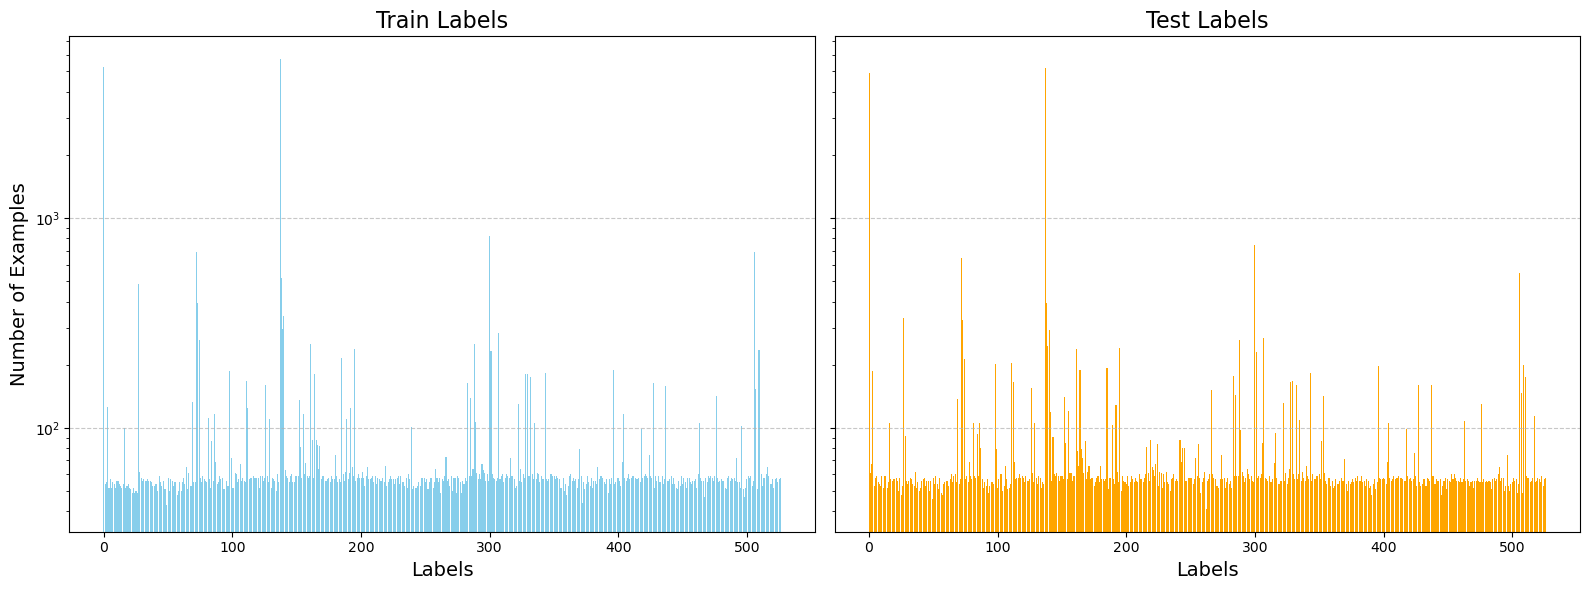

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].bar(range(len(label_count)), label_count, color='skyblue')
axes[0].set_title('Train Labels', fontsize=16)
axes[0].set_xlabel('Labels', fontsize=14)
axes[0].set_ylabel('Number of Examples', fontsize=14)
axes[0].set_yscale('log')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(range(len(test_label_count)), test_label_count, color='orange')
axes[1].set_title('Test Labels', fontsize=16)
axes[1].set_xlabel('Labels', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


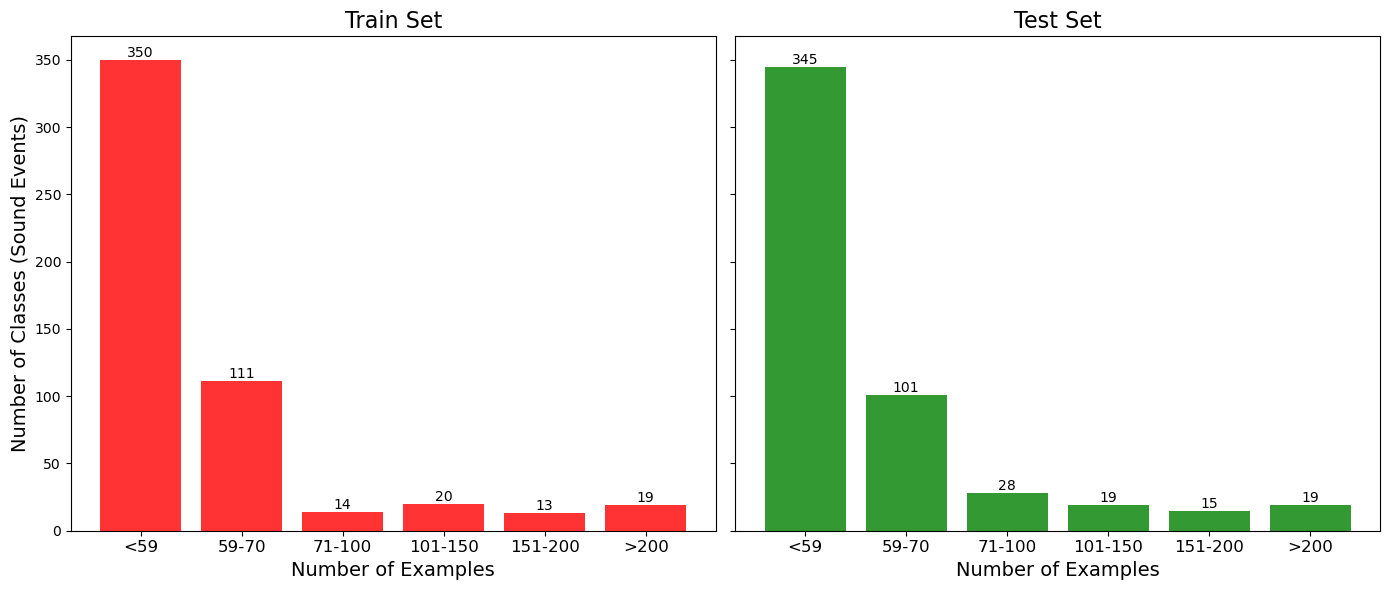

In [44]:
bins = [0, 59, 70, 100, 150, 200, float('inf')]
bin_labels = ["<59", "59-70", "71-100", "101-150", "151-200", ">200"]

train_binned_counts = np.histogram(label_count, bins=bins)[0]
test_binned_counts = np.histogram(test_label_count, bins=bins)[0]

x = np.arange(len(bin_labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(x, train_binned_counts, color='red', alpha=0.8)
axes[0].set_title('Train Set', fontsize=16)
axes[0].set_xlabel('Number of Examples', fontsize=14)
axes[0].set_ylabel('Number of Classes (Sound Events)', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(bin_labels, fontsize=12)
axes[0].bar_label(axes[0].containers[0])

axes[1].bar(x, test_binned_counts, color='green', alpha=0.8)
axes[1].set_title('Test Set', fontsize=16)
axes[1].set_xlabel('Number of Examples', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(bin_labels, fontsize=12)
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()


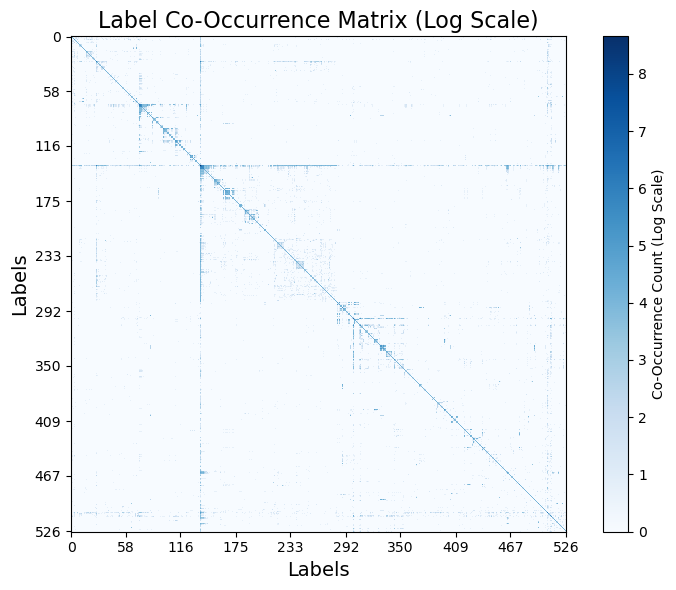

In [22]:
co_occurrence = np.dot(labels.T, labels)

plt.figure(figsize=(8, 6))
plt.imshow(np.log1p(co_occurrence), interpolation='nearest', cmap='Blues')
plt.colorbar(label="Co-Occurrence Count (Log Scale)")

plt.xticks(ticks=np.linspace(0, labels.shape[1]-1, 10, dtype=int), labels=np.linspace(0, labels.shape[1]-1, 10, dtype=int))
plt.yticks(ticks=np.linspace(0, labels.shape[1]-1, 10, dtype=int), labels=np.linspace(0, labels.shape[1]-1, 10, dtype=int))

plt.title("Label Co-Occurrence Matrix (Log Scale)", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Labels", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components=2, random_state=42)
mds_embedding = mds.fit_transform(X_tr_mean)

In [11]:
from sklearn.neighbors import RadiusNeighborsClassifier

In [23]:
rnc_mfcc = MultiOutputClassifier(
    RadiusNeighborsClassifier(
        radius=5.0,         # Increased radius to accommodate more neighbors
        weights='uniform',  # Use 'distance' for weighted neighbors
        algorithm='auto',   # Auto-select the best algorithm
        outlier_label=-1,   # Label for outliers (you can set any value, here it's -1)
        n_jobs=-1           # Use all processors for parallelization
    )
)

In [24]:
rnc_mfcc.fit(X_tr_mean, y_tr)

MultiOutputClassifier(estimator=RadiusNeighborsClassifier(n_jobs=-1,
                                                          outlier_label=-1,
                                                          radius=5.0))

In [ ]:
y_te_pred_rnc_mfcc = rnc_mfcc.predict(X_te_mean)

In [29]:
calculate_map(y_te, y_te_pred_rnc_mfcc)

[np.float64(0.2837943842391581), np.float64(0.27551257932439616), np.float64(0.2623451300199005), np.float64(0.1269521779616609), np.float64(0.11782028201598255)]


np.float64(0.008333576827034053)

In [30]:
X_tr = extract_chroma_features(data)

/ext3/miniforge3/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [31]:
X_tr.shape

(20550, 1, 12, 1002)

In [35]:
X_tr_flat = X_tr.squeeze()

In [40]:
X_tr_flat.resize(X_tr.shape[0], X_tr.shape[-1]*X_tr.shape[-2])

In [43]:
X_te_chroma = extract_chroma_features(test_data).squeeze()

/ext3/miniforge3/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [44]:
X_te_chroma.resize(X_te_chroma.shape[0], X_te_chroma.shape[-1]*X_te_chroma.shape[-2])

In [32]:
rnc_cf = MultiOutputClassifier(
    RadiusNeighborsClassifier(
        radius=5.0,         # Increased radius to accommodate more neighbors
        weights='uniform',  # Use 'distance' for weighted neighbors
        algorithm='auto',   # Auto-select the best algorithm
        outlier_label=-1,   # Label for outliers (you can set any value, here it's -1)
        n_jobs=-1           # Use all processors for parallelization
    )
)

In [42]:
rnc_cf.fit(X_tr_flat, y_tr)

MultiOutputClassifier(estimator=RadiusNeighborsClassifier(n_jobs=-1,
                                                          outlier_label=-1,
                                                          radius=5.0))

In [ ]:
y_te_pred_rnc_cf = rnc_cf.predict(X_te_chroma)

/ext3/miniforge3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:819: UserWarning: Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:819: UserWarning: Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:819: UserWarning: Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:819: UserWarning: Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/ext3/miniforge3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:819: UserWarning: Out

In [ ]:
calculate_map(y_te, y_te_pred_rnc_cf)